In [ ]:
#@title Importing Modules
%%capture
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/Shareddrives/Aircraft Engine Project')

!pip install ambiance

import Real_Turbofan_Engine
import Aircraft
import Mission

import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np

from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

from Non_Dominated_Sorting import sort_vectors
from Genetic_Algorithm import Genetic_Algorithm

from ambiance import Atmosphere

# Aircraft Selection

\begin{array}{lcc}
  \text{} & \text{Boeing 737} & \text{Airbus 320} \\
  \hline
  \text{Fuel Capacity} & 22.84 & 21.685 \\
  \text{Payload} & 16.6 & 20.882 \\
  \text{Structure} & 39.5 & 41.145 \\
\end{array}
*All values are in metric tonnes \\
References - \\
1. https://modernairliners.com/boeing-737/boeing-737-specifications/ \\
2. https://modernairliners.com/airbus-a320-introduction/airbus-a320-specs/


In [ ]:
#@title Aircraft
display(Aircraft.aircraft_widget)

ToggleButtons(description='Aircraft:', options=(('Airbus A320', <Aircraft.Aircraft object at 0x7fd31d81d190>),…

# Mission Details

\begin{array}{lcc}
  \text{Location} & \text{Distance} \\
  \hline
   \text{Mumbai} & 441 \\
   \text{Delhi} & 775 \\
  \text{Kolkata}& 1617 \\
\end{array}



*All distances are in Km

In [ ]:
#@title Mission Details
display(Mission.range_widget, Mission.altitude_widget, Mission.speed_widget)

FloatSlider(value=400.0, description='Range (km)', max=2000.0, min=400.0, readout_format='.1f', step=50.0, sty…

FloatSlider(value=35000.0, description='Altitude (ft)', max=42000.0, min=35000.0, readout_format='.1f', step=1…

FloatSlider(value=1000.0, description='Speed (km/hr)', max=1300.0, min=700.0, readout_format='.1f', step=0.01,…

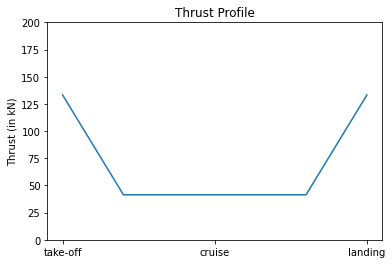

In [ ]:
#@title Thrust and Fuel Estimations

mission = Mission.Mission()
mission.range = Mission.range_widget.value * 1E3
mission.altitude = Mission.altitude_widget.value * 0.3048
mission.speed = Mission.speed_widget.value * 0.277778

fuel_required, thrust_requirements = mission.getThrustRequirements(
    Aircraft.aircraft_widget.value,
    Aircraft.aircraft_widget.value.fuel_capacity
)

thrust_fig, thrust_ax = plt.subplots()

thrust_ax.set_ylim([0, 200])

thrust_ax.plot(
    [0, 0.8, 1, 3, 3.2, 4],
    np.array(thrust_requirements) / 1E3
)

thrust_ax.set_xticks([0, 2, 4])
thrust_ax.set_xticklabels(['take-off', 'cruise', 'landing'])

thrust_ax.set_ylabel('Thrust (in kN)')
thrust_ax.set_title('Thrust Profile')

plt.show()

# Schematics of Turbofan Engine
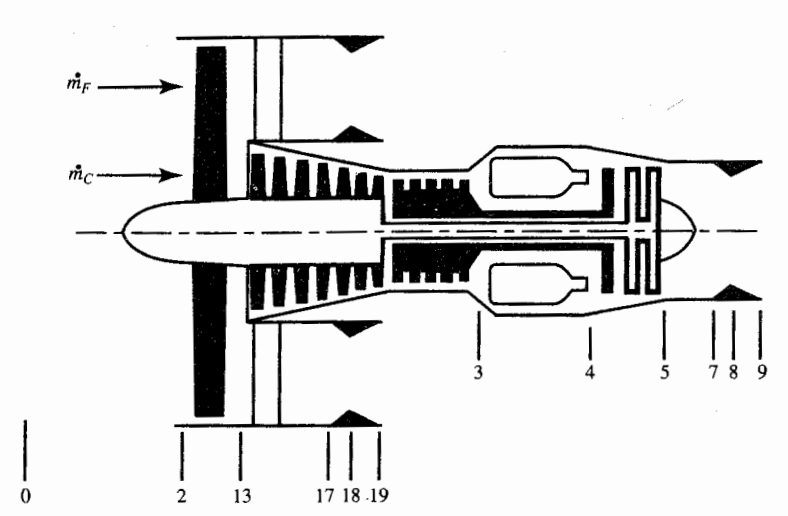

# Engine Analysis

In [ ]:
#@title Engine Configuration

display(
  Real_Turbofan_Engine.alpha_widget,
  Real_Turbofan_Engine.pi_c_widget,
  Real_Turbofan_Engine.pi_f_widget,
  Real_Turbofan_Engine.tech_level_widget
)

FloatSlider(value=1.0, description='Bypass Ratio', max=10.0, readout_format='.1f', style=SliderStyle(descripti…

FloatSlider(value=10.0, description='Compressor Compression Ratio', max=35.0, min=10.0, readout_format='.1f', …

FloatSlider(value=1.5, description='Fan Compression Ratio', max=5.0, min=1.0, readout_format='.1f', step=0.01,…

Dropdown(description='Level of Technology', index=2, options=(('1', 0), ('2', 1), ('3', 2), ('4', 3)), style=D…

####Fuel details
#####Jet A
Net Heat of Combustion = 42.8 MJ/kg



In [ ]:
#@title Engine Analysis
Real_Turbofan_Engine.setUpEngine(
  mission.speed,
  mission.altitude,
  Real_Turbofan_Engine.alpha_widget.value,
  Real_Turbofan_Engine.pi_c_widget.value,
  Real_Turbofan_Engine.pi_f_widget.value,
  Real_Turbofan_Engine.tech_level_widget.value
)

Real_Turbofan_Engine.engine.initializeProblem()
Real_Turbofan_Engine.engine.performAnalysis()

print(
    'Specific Thrust of the engine :\t\t', round(Real_Turbofan_Engine.engine.getSpecificThrust()[0],2),'N / kg/s\n'
    'Thrust Specific Fuel Consumption :\t', round(Real_Turbofan_Engine.engine.getThrustSpecificFuelConsumtion()[0],7),' kg/s / N\n'
    'Thermal Efficiency of the engine :\t', round(Real_Turbofan_Engine.engine.getThermalEfficiency()[0]*100,2) ,'%\n'
    'Propulsive Efficiency of the engine :\t', round(Real_Turbofan_Engine.engine.getPropulsiveEfficiency()[0]*100,2),'%\n'
)

Specific Thrust of the engine :		 372.8 N / kg/s
Thrust Specific Fuel Consumption :	 3.68e-05  kg/s / N
Thermal Efficiency of the engine :	 12.81 %
Propulsive Efficiency of the engine :	 56.55 %



# Engine Optimization

Cycle Analysis during Optimization process is done for an Ideal Engine

In [ ]:
#@title Setting up Optimization Functions
# alpha, pi_c, pi_f, M_0, h, T_t4

ideal_engine = Real_Turbofan_Engine.TurboFanAnalysis()

ideal_engine.setFlightMachNumber(0.8)
ideal_engine.setFlightConditions(12000)
ideal_engine.setFuelInfo(42.8E6)
ideal_engine.setInletOutletProperties()
ideal_engine.setBurnerProperties()
ideal_engine.setCompressorProperties(35)
ideal_engine.setFanProperties(1.5)
ideal_engine.setTurbineProperties(1600)
ideal_engine.setBypassRatio(5)

ideal_engine.initializeProblem()

max_values = np.array([10.0, 40.0, 5.0, 1.0, 15E3, Real_Turbofan_Engine.T_t4[Real_Turbofan_Engine.tech_level_widget.value]])
min_values = np.array([ 0.0,  1.0, 1.0, 0.5,  5E3,  800.0])
resolution = np.array([ 0.1,  0.1, 0.1, 0.1,  1E2,   10.0])

num_bits = np.array( np.ceil( np.log2( (max_values - min_values) / resolution ) ), dtype=int) + 1
bits_conversion_array = [np.power(2, np.arange(bits)) for bits in num_bits]

def bits_to_input(bits) :

  i = 0
  j = num_bits[0]
  alpha = min_values[0] + (max_values[0] - min_values[0]) * np.sum(bits[:, i:j] * bits_conversion_array[0], axis=1) / (2**num_bits[0] - 1)

  i = j
  j += num_bits[1]
  pi_c = min_values[1] + (max_values[1] - min_values[1]) * np.sum(bits[:, i:j] * bits_conversion_array[1], axis=1) / (2**num_bits[1] - 1)

  i = j
  j += num_bits[2]
  pi_f = min_values[2] + (max_values[2] - min_values[2]) * np.sum(bits[:, i:j] * bits_conversion_array[2], axis=1) / (2**num_bits[2] - 1)

  i = j
  j += num_bits[3]
  M_0 = min_values[3] + (max_values[3] - min_values[3]) * np.sum(bits[:, i:j] * bits_conversion_array[3], axis=1) / (2**num_bits[3] - 1)

  i = j
  j += num_bits[4]
  h = min_values[4] + (max_values[4] - min_values[4]) * np.sum(bits[:, i:j] * bits_conversion_array[4], axis=1) / (2**num_bits[4] - 1)

  i = j
  j += num_bits[5]
  T_t4 = min_values[5] + (max_values[5] - min_values[5]) * np.sum(bits[:, i:j] * bits_conversion_array[5], axis=1) / (2**num_bits[5] - 1)

  return np.array([alpha, pi_c, pi_f, M_0, h, T_t4])

def analyseEngine(alpha, pi_c, pi_f, M_0, h, T_t4) :
  
  ideal_engine.setFlightMachNumber(M_0)
  ideal_engine.setFlightConditions(h)

  ideal_engine.setCompressorProperties(pi_c)
  ideal_engine.setFanProperties(pi_f)
  ideal_engine.setBypassRatio(alpha)

  ideal_engine.setTurbineProperties(T_t4)

  ideal_engine.initializeProblem()
  ideal_engine.performAnalysis()

  pass

def engineFitnessFunction(bits) :

  alpha, pi_c, pi_f, M_0, h, T_t4 = bits_to_input(bits)
  
  analyseEngine(alpha, pi_c, pi_f, M_0, h, T_t4)

  return np.column_stack((ideal_engine.getSpecificThrust(), - ideal_engine.getThrustSpecificFuelConsumtion()))

In [ ]:
#@title Optimizing
%%capture
problem = Genetic_Algorithm()

problem.set_dimensions(sum(num_bits), 2)
problem.set_number_of_chromosomes(1000)
problem.set_probabilities(0.8, 0.40)
problem.set_fitness_function(engineFitnessFunction)
problem.set_sorting_function(sort_vectors)

problem.begin()

Pareto_fronts = []
Other_chromosomes = []

for i in range(50) :
    
    problem.iterate()
    Pareto_fronts.append(problem.get_Pareto_Front_fitness_values())
    Other_chromosomes.append(problem.get_non_Pareto_Front_fitness_values())

problem.stop_iterations()

In [ ]:
#@title Setting up Visualization Methods
%%capture
fig, ax = plt.subplots(figsize=(12,8))

points, = ax.plot(  Pareto_fronts[0][:, 0], 
                    -Pareto_fronts[0][:, 1],
                    'bo', ms=5, color='blue',
                    label='Points on Pareto Front')

other_points, = ax.plot(    Other_chromosomes[0][:, 0],
                            -Other_chromosomes[0][:, 1],
                            'bo', ms=3, color='red',
                            label='Points not on Pareto Front')

# set axes labels
ax.set_xlabel(r'Specific Thrust (in $\frac{N}{kg/s}$)', fontsize=15)
ax.set_ylabel(r'Thrust Specific Fuel Consumption (in $\frac{kg/s}{N}$)', fontsize=15)

ax.set_ylim(bottom=0)

# set title
ax.set_title('Pareto Front at Generation # 0', fontsize=15)

# Grid
ax.minorticks_on()
ax.grid(which='minor', ls='--', c='green', alpha=0.5)

ax.grid(which='major', c='grey', alpha=0.5)

# Legend
ax.legend(fontsize=15, loc=2)

def animate(i) :

    # set title
    ax.set_title('Pareto Front at Generation # ' + str(i+1), fontsize=15)

    # print(Pareto_fronts[i])
    points.set_data(Pareto_fronts[i][:, 0], -Pareto_fronts[i][:, 1])
    other_points.set_data(Other_chromosomes[i][:, 0], -Other_chromosomes[i][:, 1])
    # points.set_markersize(10)

    return points, other_points, 

anim = FuncAnimation(fig, animate, frames=50, interval=5E3/50)


In [ ]:
#@title Visualizing the Optimization Process
anim

Cycle Analysis for a Real Engine at Cruise Conditions

In [ ]:
#@title Finding the best Engine Design
%%capture

best_genes = problem.get_Pareto_Front_chromosomes()

alpha, pi_c, pi_f, M_0, h, T_t4 = bits_to_input(best_genes)

air = Atmosphere(h)
a_0 = air.speed_of_sound
V_0 = M_0 * a_0

Real_Turbofan_Engine.setUpEngine(
  V_0,
  h,
  alpha,
  pi_c,
  pi_f,
  Real_Turbofan_Engine.tech_level_widget.value
)

Real_Turbofan_Engine.engine.initializeProblem()
Real_Turbofan_Engine.engine.performAnalysis()

# analyseEngine(alpha, pi_c, pi_f, M_0, h, T_t4)

specific_thrust = Real_Turbofan_Engine.engine.getSpecificThrust()
TSFC = Real_Turbofan_Engine.engine.getThrustSpecificFuelConsumtion()

args = np.argwhere(np.invert(np.isnan(TSFC))).reshape(-1)

TSFC = TSFC[args]
specific_thrust = specific_thrust[args]

alpha = alpha[args]
pi_c = pi_c[args]
pi_f = pi_f[args]
M_0  = M_0[args]
h = h[args]
T_t4 = T_t4[args]

air = Real_Turbofan_Engine.ambiance.Atmosphere(h)

m_dot_0 = air.density * 19.34 * M_0 * air.speed_of_sound

best_arg = np.argmin(
    TSFC[
         np.where(
            np.logical_and(specific_thrust != np.nan, specific_thrust * m_dot_0 >= thrust_requirements[2])
         )
    ]
)

In [ ]:
#@title Optimum Design Parameters
print('By-Pass Ratio: \t\t\t',round(alpha[best_arg],2))
print('Compressor Ratio: \t\t',round(pi_c[best_arg],2))
print('Fan Compression Ratio: \t\t',round(pi_f[best_arg],2))
print('Mach Number: \t\t\t',round(M_0[best_arg],2))
print('Altitude: \t\t\t',round(h[best_arg],2), 'm')
print('Turbine Inlet Temperature: \t',round(T_t4[best_arg],2),'K')

By-Pass Ratio: 			 9.49
Compressor Ratio: 		 34.7
Fan Compression Ratio: 		 1.85
Mach Number: 			 0.5
Altitude: 			 14098.04 m
Turbine Inlet Temperature: 	 1057.49 K


In [ ]:
#@title Optimized Performance Parameters
print(
    'Specific Thrust of the engine :\t\t', round(specific_thrust[best_arg],2),'N / kg/s\n'
    'Thrust Specific Fuel Consumption :\t', round(TSFC[best_arg],7),' kg/s / N\n'
    'Thermal Efficiency of the engine :\t', round(Real_Turbofan_Engine.engine.getThermalEfficiency()[args][best_arg]*100,2) ,'%\n'
    'Propulsive Efficiency of the engine :\t', round(Real_Turbofan_Engine.engine.getPropulsiveEfficiency()[args][best_arg]*100,2),'%\n'
)

Specific Thrust of the engine :		 193.46 N / kg/s
Thrust Specific Fuel Consumption :	 1.86e-05  kg/s / N
Thermal Efficiency of the engine :	 26.76 %
Propulsive Efficiency of the engine :	 49.6 %



In [ ]:
#@title Optimized Flight Details
print('Thrust at Cruise :\t', round(m_dot_0[best_arg] * specific_thrust[best_arg] / 1000, 2), 'kN')
print('Fuel Consumption Rate :\t', round(m_dot_0[best_arg] * specific_thrust[best_arg] * TSFC[best_arg], 2), 'kg / s')
print('Fuel Required :\t', round(m_dot_0[best_arg] * specific_thrust[best_arg] * TSFC[best_arg] * Mission.range_widget.value * 1000 / (M_0[best_arg] * air.speed_of_sound[best_arg] * 1000), 2), 'tonnes')

Thrust at Cruise :	 123.86 kN
Fuel Consumption Rate :	 2.31 kg / s
Fuel Required :	 6.26 tonnes
